In [368]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import plyfile

In [24]:
bunny = r"C:\Users\fdegr\Downloads\bunny.tar\bunny\reconstruction\bun_zipper.ply"

with open(bunny, "rb") as f:
    bunny_ply = plyfile.PlyData.read(f)

In [162]:
def rot_x(theta):
    m = np.array([
        1, 0, 0,
        0, np.cos(theta), -np.sin(theta),
        0, np.sin(theta), np.cos(theta)
    ]).reshape(3,3)

    return m


def rot_y(theta):
    m = np.array([
        np.cos(theta), 0, -np.sin(theta),
        0,             1,      0,
        np.sin(theta),0, np.cos(theta)
    ]).reshape(3,3)

    return m


def rot_z(theta):
    m = np.array([
        np.cos(theta), -np.sin(theta), 0,
        np.sin(theta), np.cos(theta), 0,
        0, 0, 1,
    ]).reshape(3,3)

    return m



def fov2focal(fov, size):
    return size / (np.tan(float(fov)/2)) / 2


def focal2fov(focal, size):
    return 2 * np.arctan2(float(size) / 2, focal)

In [650]:
from numba import njit


# @njit
def bbox(pcl):
    pcl_flat = pcl.reshape(-1, 3)
    count = pcl_flat.shape[0]
    xmin, xmax = np.infty, -np.infty
    ymin, ymax = np.infty, -np.infty
    zmin, zmax = np.infty, -np.infty

    for i in range(count):
        x = pcl_flat[i, 0]
        y = pcl_flat[i, 1]
        z = pcl_flat[i, 2]

        if x<xmin:
            xmin = x
        if x >= xmax:
            xmax = x

        if y < ymin:
            ymin = y
        if y >= ymax:
            ymax = y


        if z < zmin:
            zmin = z
        if z >= zmax:
            zmax = z

    return xmin, xmax, ymin, ymax, zmin, zmax

bbox(np.array([
    [-0.2, -0.4, -0.6],
    [ 0.3, -0.5, -0.6],
    [-0.2,  0.4, -0.6],
    [ 0.3,  0.4, -0.6],
    [-0.2, -0.5,  0.7],
    [ 0.3, -0.4,  0.7],
    [-0.2,  0.4,  0.7],
    [ 0.3,  0.5,  0.7],
]))



(-0.2, 0.3, -0.5, 0.5, -0.6, 0.7)

In [ ]:
def bbox_np(pcl):
    pcl = pcl.reshape(-1, 3)
    np.argmax()

35947


(-0.0, 0.2)

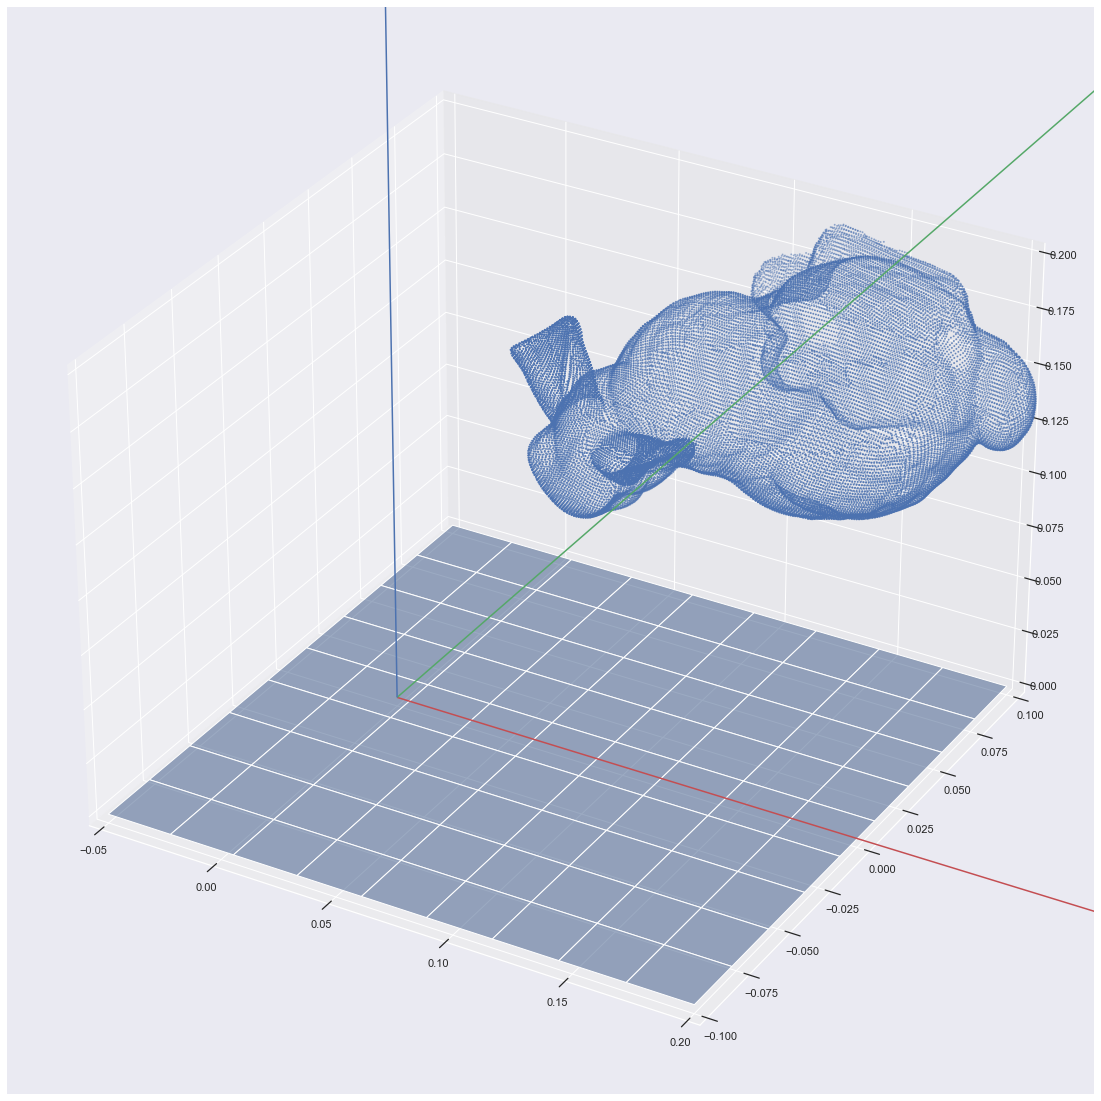

In [724]:
bunny_pcl = np.stack([
    bunny_ply['vertex'].data['x'],
    bunny_ply['vertex'].data['y'],
    bunny_ply['vertex'].data['z']
    ], axis=-1)


theta = 1* np.pi
#theta = 0
bunny_pcl_r = (rot_z(theta) @ bunny_pcl.T).T
theta_y = np.pi
bunny_pcl_r = (rot_y(theta_y) @ bunny_pcl_r.T).T


# bunny_pcl_r *= 10
bunny_pcl_r[:,0] += 0.15
bunny_pcl_r[:,1] += 0.15
bunny_pcl_r[:,2] += 0.15

print(len(bunny_pcl_r))
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')

pxx, pyy = np.meshgrid(np.linspace(-0.05, 0.2, 10), np.linspace(-0.1, 0.1, 10))
pz = 0*pxx

# plot the plane
ax.plot_surface(pxx, pyy, pz, alpha=0.5)

def plot_axes(ax):
    x, y, z = np.zeros((3,3))
    u, v, w = np.array([[1,0,0],[0,1,0],[0,0,1]])
    ax.quiver(x,y,z,u,v,w,arrow_length_ratio=0.1, color=['r', 'g', 'b'])

plot_axes(ax)

ax.scatter(bunny_pcl_r[:,0], bunny_pcl_r[:,1], bunny_pcl_r[:,2], s=1)
bunny_bbox = bbox(bunny_pcl_r)
# ax.set_xlim(bunny_bbox[0], bunny_bbox[1])
# ax.set_ylim(bunny_bbox[2], bunny_bbox[3])
# ax.set_zlim(bunny_bbox[4], bunny_bbox[5])

ax.set_xlim(-0.05, 0.2)
ax.set_ylim(-0.1, 0.1)
ax.set_zlim(-0.0, 0.2)



In [4]:
h, w = 100, 100

xs, ys = np.meshgrid(np.linspace(-20, 20, w), np.linspace(-20, 20, h))
zs = np.ones_like(xs) * 20

pcl = np.stack([xs, ys, zs], axis=-1)



(100, 100, 3)

In [403]:
fx, fy = 70.0, 70.0
cx, cy = w/2, h/2
k1, k2, k3 = 0.02, 0.0, 0.0
p1, p2 = 0.0, 0.0
K = np.array([
    fx, 0, cx,
     0, fy, cy,
     0, 0, 1
]).reshape(3,3)
dist_coeffs = np.array([k1, k2, p1, p2, k3])
tvec = np.array([0.0, 0.0, 0.0])
rvec = np.eye(3)

In [261]:
def project_points(points, k, dist_coeffs):
    uvw = k @ points.reshape(-1, 3).T
    u = uvw[0,:] / uvw[2,:]
    v = uvw[1,:] / uvw[2,:]

    return u, v


def project_points_dist(points, k, dist_coeffs):
    XYZ = points.reshape(-1, 3).T
    x = XYZ[0,:] / XYZ[2,:]
    y = XYZ[1,:] / XYZ[2,:]

    r2 = x*x + y*y
    r4 = r2*r2
    r6 = r4*r4
    a1 = 2*x*y
    a2 = r2 + 2*x*x
    a3 = r2 + 2*y*y
    k1, k2, p1, p2, k3 = dist_coeffs

    xd = x * (1+k1*r2 + k2*r4 + k3*r6) + p1*a1 + p2*a2
    yd = y * (1+k1*r2 + k2*r4 + k3*r6) + p1*a3 + p2*a1

    fx = k[0,0]
    fy = k[1,1]
    cx = k[0,2]
    cy = k[1,2]
    u =  xd * fx + cx
    v =  yd * fy + cy

    return u, v

In [ ]:


class ProjectPoints:
    def __init__(self, intrinsics, dist_coeff):
        ...

    def project(self, points):
        ...

In [409]:
import numpy as np
import pyopencl as cl

a_np = np.random.rand(50000).astype(np.float32)
b_np = np.random.rand(50000).astype(np.float32)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

prg = cl.Program(ctx, """
__kernel void projectpoint(
    __global const float *p3d_g, __constant const float *intrinsics,  __constant const float *dist_coeff, __global float *u_g, __global float *v_g)
{
  int gid = get_global_id(0);

  float x =

  res_g[gid] = a_g[gid] + b_g[gid];
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
knl = prg.sum  # Use this Kernel object for repeated calls
knl(queue, a_np.shape, None, a_g, b_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np - (a_np + b_np))
print(np.linalg.norm(res_np - (a_np + b_np)))
assert np.allclose(res_np, a_np + b_np)

[0. 0. 0. ... 0. 0. 0.]
0.0


In [725]:
# %%timeit

# print(f"hfov: {np.rad2deg(focal2fov(fx, w))}")
# print(f"vfov: {np.rad2deg(focal2fov(fy, h))}")
u, v = project_points(bunny_pcl_r, K, dist_coeffs)



In [726]:
# %%timeit
ud, vd = project_points_dist(bunny_pcl_r, K, dist_coeffs)

In [727]:
#  %%timeit

cv_projected, _ = cv2.projectPoints(bunny_pcl_r, cameraMatrix=K, distCoeffs=dist_coeffs, rvec=rvec, tvec=tvec)

35947
29198
34132
34028


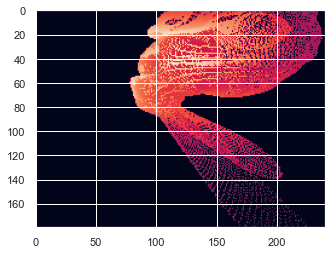

In [706]:
uv_cv = np.squeeze(cv_projected)
uv_cv
h, w  = 180, 240
u_cv = uv_cv[:, 0]
v_cv = uv_cv[:, 1]

print(len(u_cv))
print(len(np.where((u_cv>=0) * (u_cv<h))[0]))
print(len(np.where((v_cv>=0) * (v_cv<w))[0]))

unn = np.round(u_cv).astype(int)
vnn = np.round(v_cv).astype(int)


inds_int = np.where((unn>=0) * (unn<w) * (vnn>=0) * (vnn<h))[0]

# print(len(inds))
print(len(inds_int))




target = np.zeros(shape=(h, w))

np.where(unn[inds_int]> 238)


target[vnn[inds_int], unn[inds_int]]= bunny_pcl_r[inds_int, 2]

plt.imshow(target)



In [574]:

from numba import njit


def make_img(u, v, pcl):
    im = np.ones(shape=(h, w)) * 2
    uu = np.round(u).astype(int)
    vv = np.round(v).astype(int)

    inds = np.where((0<=uu) * (uu<w) * (0<=vv) * (vv<h))[0]
    uc = uu[inds]
    vc = vv[inds]

    im[vc, uc] = pcl[inds, 2]
    return im

#@njit
def make_img_zbuf(u, v, pcl):
    im = np.ones(shape=(h, w)) * 2
    uu = np.round(u).astype(int)
    vv = np.round(v).astype(int)

    inds = np.where((0<=uu) * (uu<w) * (0<=vv) * (vv<h))[0]

    for i in range(len(inds)):
        uc = uu[inds[i]]
        vc = vv[inds[i]]
        z = pcl[inds[i],2]
        if im[vc, uc] >= z:
            im[vc, uc] = z

    return im

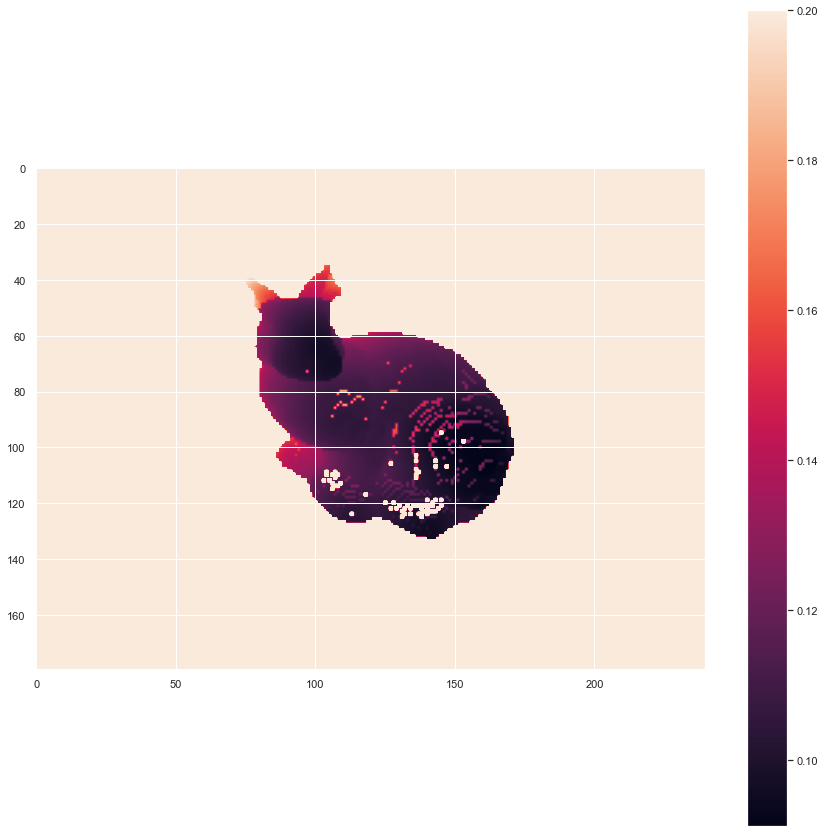

In [732]:
im = make_img_zbuf(u, v, bunny_pcl_r)
plt.figure(figsize=(15,15))
plt.imshow(im, vmax=0.20)
plt.colorbar()

In [707]:
%%timeit

im = make_img_zbuf(u, v, bunny_pcl_r)

49.4 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


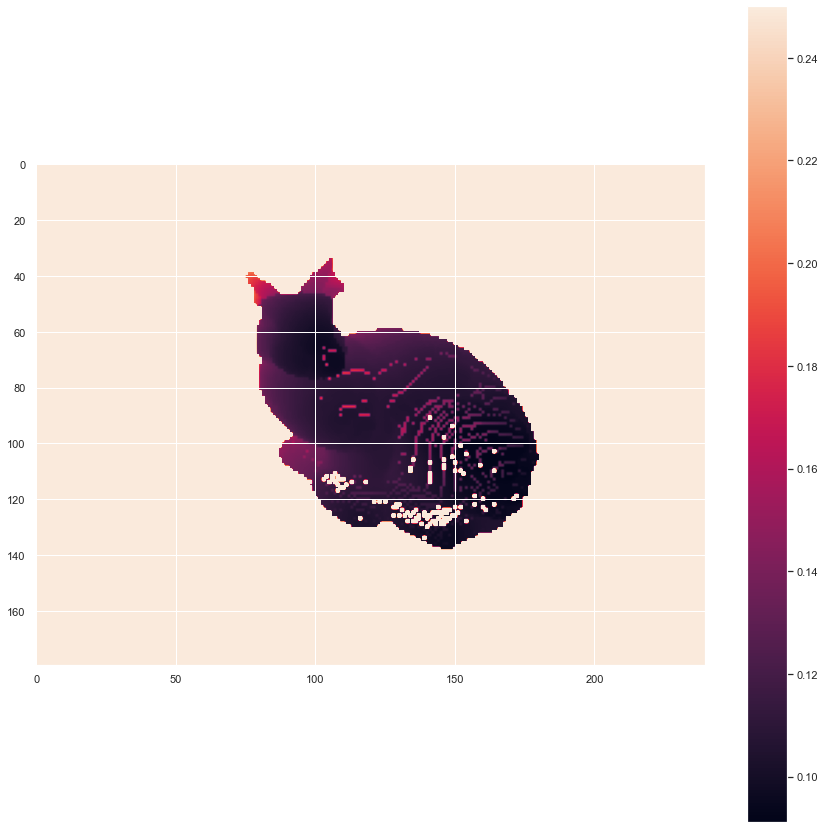

In [735]:
imd = make_img_zbuf(ud, vd, bunny_pcl_r)
plt.figure(figsize=(15,15))
plt.imshow(imd, vmax=0.25)
plt.colorbar()

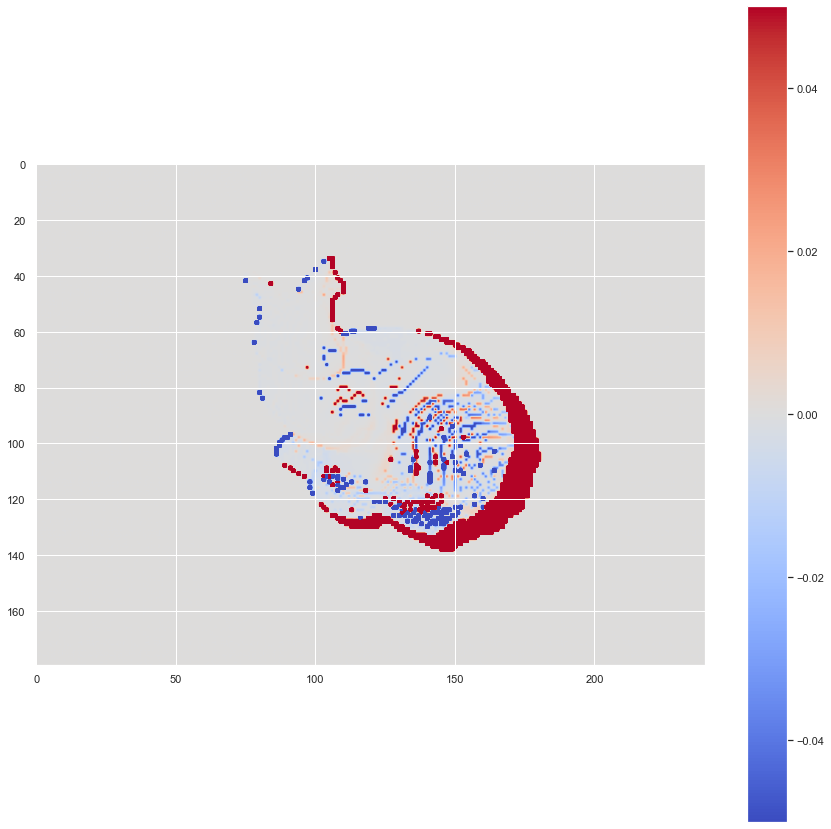

In [736]:
plt.figure(figsize=(15,15))
plt.imshow(im-imd, cmap='coolwarm', vmin=-0.05, vmax=0.05)
plt.colorbar()

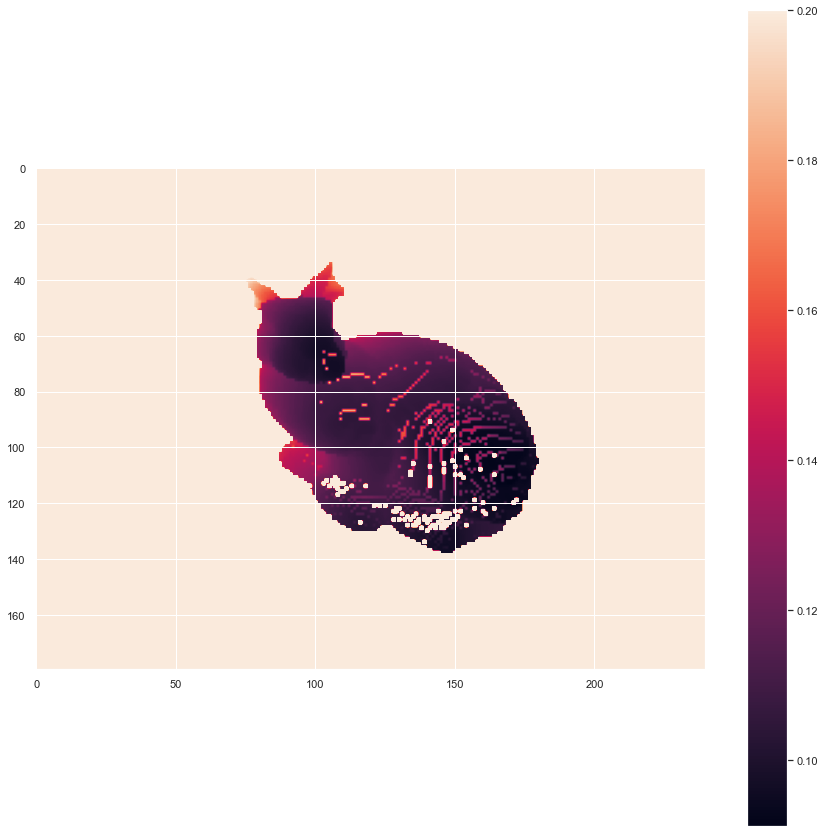

In [739]:
cv_projected = np.squeeze(cv_projected)
u_cv = cv_projected[:,0]
v_cv = cv_projected[:,1]

im_cvd = make_img_zbuf(u_cv, v_cv, bunny_pcl_r)
plt.figure(figsize=(15,15))
plt.imshow(im_cvd, vmax=0.20)
plt.colorbar()

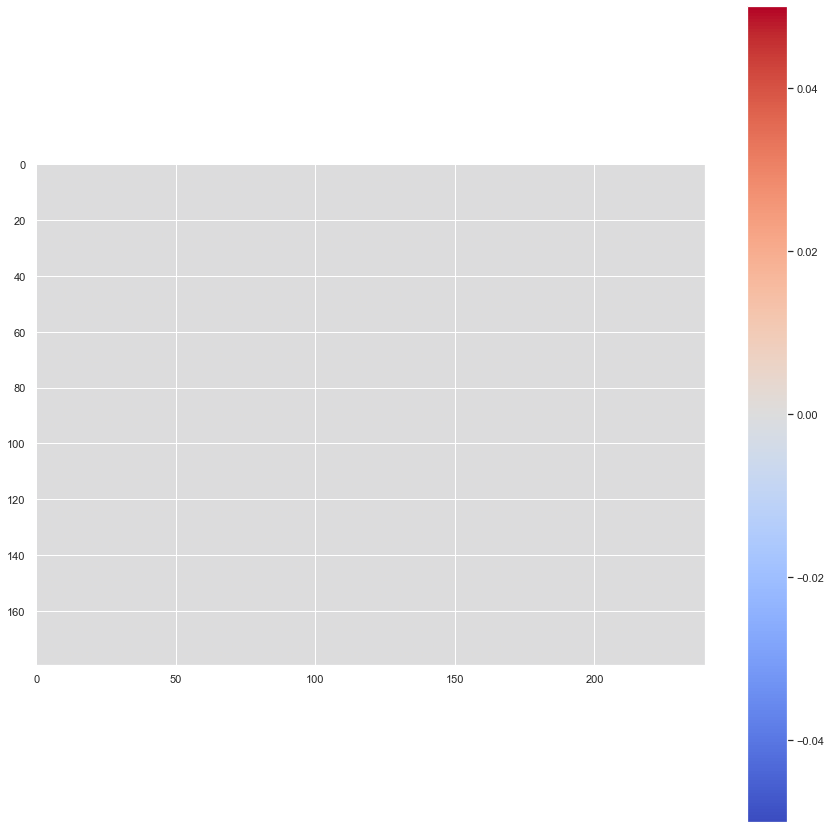

In [740]:
plt.figure(figsize=(15,15))
plt.imshow(imd-im_cvd, cmap='coolwarm', vmin=-0.05, vmax=0.05)
plt.colorbar()